# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [1]:
from google.colab import files
uploaded = files.upload()

Saving transformer_utils.py to transformer_utils.py


In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. Parameters <a name="parameters"></a>

In [3]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/app/notebooks/11_music/01_transformer/parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [4]:
from google.colab import files
uploaded = files.upload()

Saving MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi to MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi
Saving MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.midi to MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.midi
Saving MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--5.midi to MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--5.midi


In [5]:
import shutil
import os

target_directory = "/app/data/bach-cello/"
os.makedirs(target_directory, exist_ok=True)  # Create directory if it doesn't exist

for filename in uploaded.keys():
    shutil.move(filename, os.path.join(target_directory, filename))

print(f"Files moved to {target_directory}")

Files moved to /app/data/bach-cello/


In [6]:
# Load the data
file_list = glob.glob("/app/data/bach-cello/*.midi")
print(f"Found {len(file_list)} midi files")

Found 3 midi files


In [7]:
parser = music21.converter

In [8]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [9]:
!sudo apt update
!sudo apt install musescore

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,514 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,621 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,454

In [10]:
from music21 import environment
environment.set ('musescoreDirectPNGPath', '/usr/bin/mscore')

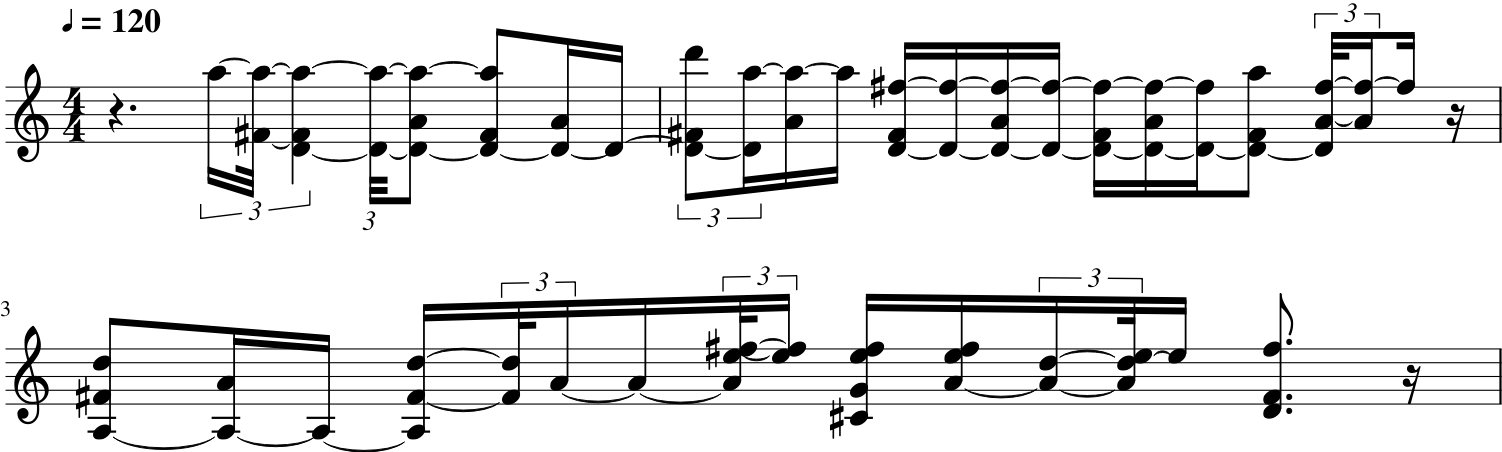

In [11]:
example_score.show()

In [ ]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7ac8200cbe50>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Piano '7 to 9 Schubert: Piano'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 1.25ql>
    {1.25} <music21.chord.Chord C2 C3 E-3 G3 C4>
    {3.75} <music21.note.Rest 16th>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.note.Rest 16th>
    {0.25} <music21.chord.Chord C2 C3 E-3 G3 C4>
    {0.5} <music21.chord.Chord C2 C3 F3 G#3 D4>
    {0.75} <music21.note.Rest dotted-eighth>
    {1.5} <music21.chord.Chord C2 C3 F3 G#3 D4>
    {1.75} <music21.note.Rest 2.25ql>
{8.0} <music21.stream.Measure 3 offset=8.0>
    {0.0} <music21.chord.Chord C3 G3 B-3 E4>
    {1.3333} <music21.chord.Chord C3 G3 B-3 F4>
    {1.5} <music21.chord.Chord C3 G3 B-3 F4 G4 G#4>
    {1.5833} <music21.chord.Chord C3 G3 B-3 G4 G#4>
    {1.75} <music21.chord

In [ ]:
import os

# Define the parsed data directory
PARSED_DATA_PATH = "/app/notebooks/11_music/01_transformer/parsed_data/"

# Ensure the directory exists
os.makedirs(PARSED_DATA_PATH, exist_ok=True)
print(f"Directory created or already exists: {PARSED_DATA_PATH}")

Directory created or already exists: /app/notebooks/11_music/01_transformer/parsed_data/


In [ ]:
PARSED_DATA_PATH = "/app/notebooks/11_music/01_transformer/parsed_data/"
notes, durations = parse_midi_files(file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH)
print("Parsing completed.")

1 Parsing /app/data/bach-cello/MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--1.midi


<ipython-input-16-d71a90e61119>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH)


3223 notes parsed
2 Parsing /app/data/bach-cello/MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav.midi
14157 notes parsed
Building sequences of length 51
Parsing completed.


In [ ]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 B-4 B4 B4 B4 B-4 B-4 B4 B4 B4 D5 E5 E5 E5 D5 rest D5 G5 G5 G5 D5 D5 C5 C5 G4 G4 G#4 G#4 B4 B4 B4 B4 B4 rest G#4 G#4 C5 D5 E-5 E-5 E-5 E-5 E-5 E-5 D5 D5 E-5 E-5 F#5 F#5 G#5 G#5 ...

Duration string
 1.0 0.5 11/6 1/6 0.5 0.5 1/12 5/12 0.25 0.5 0.25 2.0 1/12 1/6 0.75 1.0 0.25 17/12 7/12 1/12 1/3 1/12 1/12 1/6 1.5 0.25 0.75 0.25 1.25 4/3 2/3 1/6 5/6 1.0 1/3 11/12 1.25 1/6 1/12 1/6 13/12 2/3 1/12 0.5 0.25 0.5 1/3 1/6 0.5 1/12 2/3 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [ ]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [ ]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         8        10
         9         6
         9        35
         9         5
         8         6
         8         6
         9         3
         9         7
         9         2
        15         6
        16         2


In [ ]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 77
0: 
1: [UNK]
2: rest
3: E-5
4: G#4
5: G4
6: C5
7: G5
8: B-4
9: B4

DURATIONS_VOCAB: length = 46
0: 
1: [UNK]
2: 0.25
3: 1/12
4: 1/3
5: 1/6
6: 0.5
7: 5/12
8: 0.75
9: 2/3


## 3. Create the Training Set <a name="create"></a>

In [ ]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [ ]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 7, 18,  7, ..., 21, 21, 21],
       [18,  7, 18, ..., 21, 21, 21],
       [ 7, 18,  7, ..., 21, 21, 21],
       ...,
       [ 8,  8, 10, ...,  7,  2,  5],
       [ 8, 10, 10, ...,  2,  5,  2],
       [10, 10, 10, ...,  5,  2, 19]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 4,  3,  3, ...,  3,  5,  2],
       [ 3,  3,  5, ...,  5,  2,  2],
       [ 3,  5,  2, ...,  2,  2,  2],
       ...,
       [ 4,  3,  6, ...,  7,  3,  3],
       [ 3,  6,  6, ...,  3,  3,  3],
       [ 6,  6, 11, ...,  3,  3,  3]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[18,  7, 18, ..., 21, 21, 21],
       [ 7, 18,  7, ..., 21, 21, 21],
       [18,  7, 18, ..., 21, 21, 21],
       ...,
       [ 8, 10, 10, ...,  2,  5,  2],
       [10, 10, 10, ...,  5,  2, 19],
       [10, 10,  9, ...,  2, 19, 10]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 3,  3,  5, ...,  5,  2,  2],
       [ 3,  5,  2, ...,  2,  2, 

## 5. Create the causal attention mask function <a name="causal"></a>

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

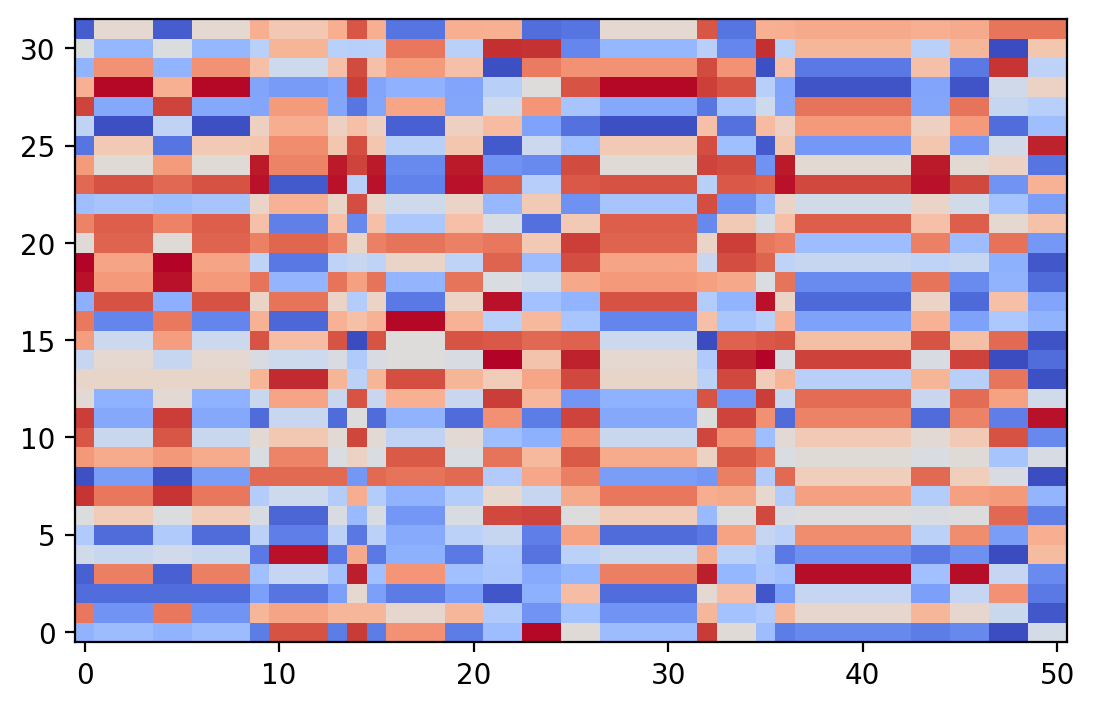

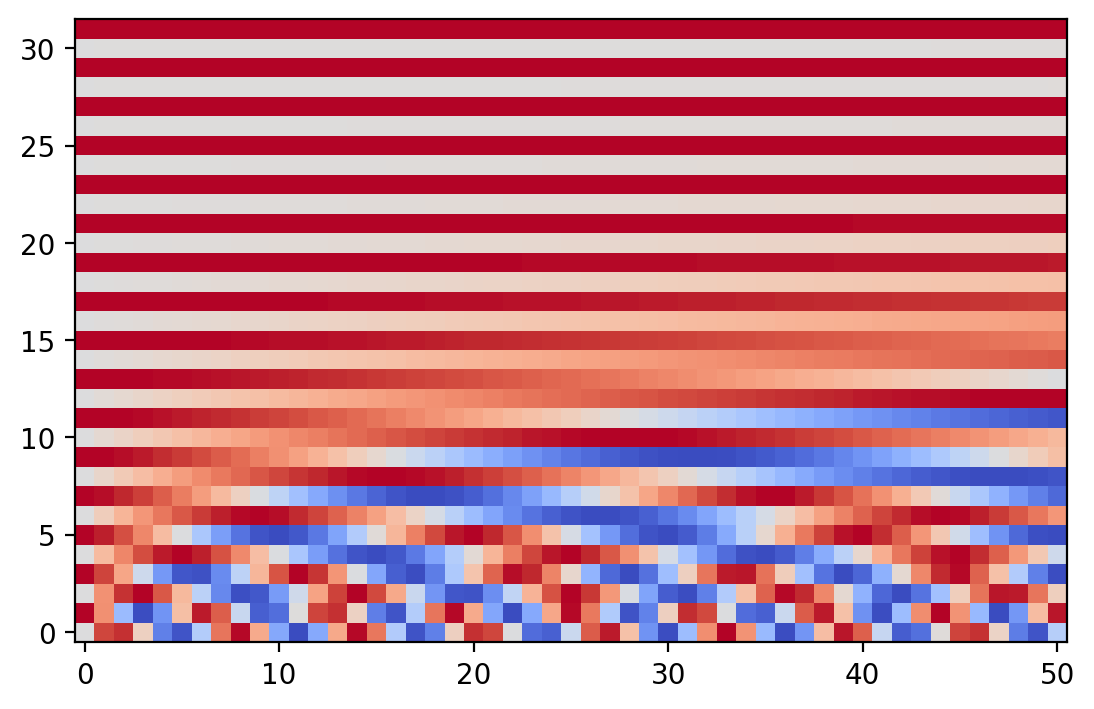

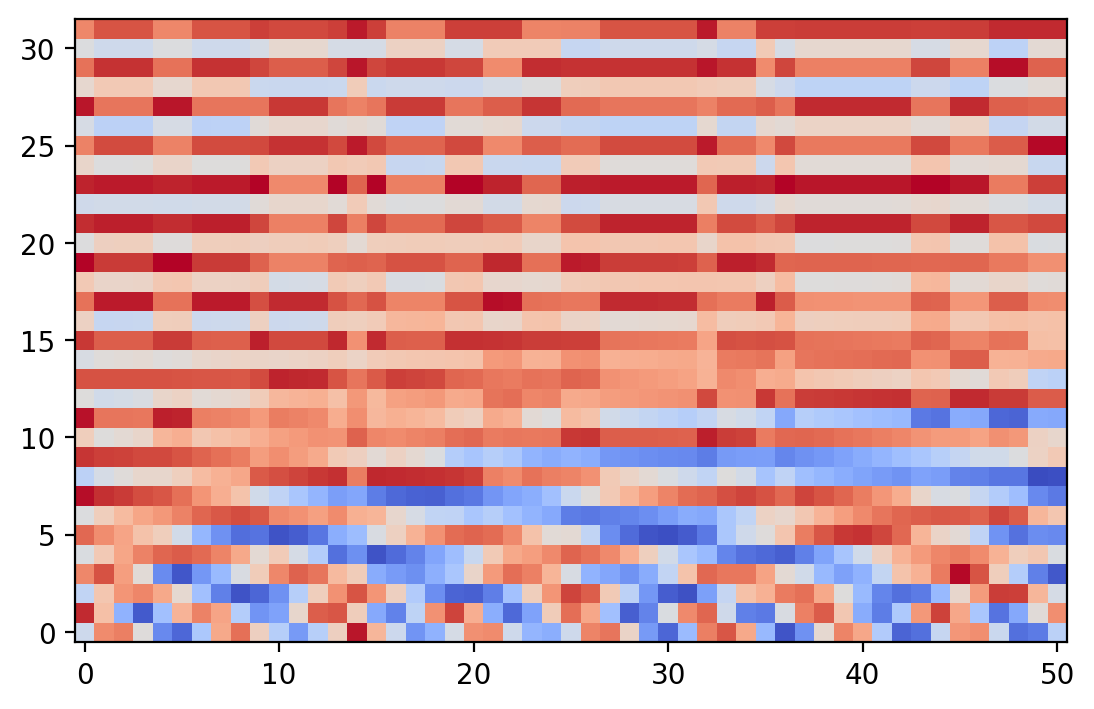

In [ ]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [ ]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          9,856 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          5,888 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 77)       │         19,789 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 46)       │         11,822 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,494,779 (5.70 MB)

 Trainable params: 1,494,779 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [ ]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/app/notebooks/11_music/01_transformer/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [ ]:
from music21 import stream, note

class MusicGenerator:
    def __init__(self, notes_vocab, durations_vocab):
        self.notes_vocab = notes_vocab
        self.durations_vocab = durations_vocab

    def generate(self, start_notes, start_durations, max_tokens=50, temperature=0.5):
        """
        Generate a sequence of notes and durations.

        Parameters:
        - start_notes: List of starting notes.
        - start_durations: List of starting durations.
        - max_tokens: Maximum number of tokens to generate.
        - temperature: Temperature for randomness (not used in this dummy implementation).

        Returns:
        - A list containing notes, durations, and a MIDI stream.
        """
        generated_notes = start_notes[:]
        generated_durations = start_durations[:]

        # Dummy logic for generating notes and durations
        for _ in range(max_tokens - len(start_notes)):
            next_note = "C4"  # Replace with your model's prediction logic
            next_duration = "0.25"  # Replace with your model's prediction logic
            generated_notes.append(next_note)
            generated_durations.append(next_duration)

        # Create a MIDI stream
        midi_stream = stream.Stream()
        for n, d in zip(generated_notes, generated_durations):
            midi_stream.append(note.Note(n, quarterLength=float(d)))

        return [{"notes": generated_notes, "durations": generated_durations, "midi": midi_stream}]

In [ ]:
from keras import callbacks  # Import the callbacks module
import os

# Ensure necessary directories exist
os.makedirs("./checkpoint", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",  # Use correct extension for weights
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

# Create a TensorBoard callback
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Ensure necessary directories exist
import os
os.makedirs("./checkpoint", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# Step 1: Define the Model
model = Sequential([
    Embedding(input_dim=128, output_dim=64, input_length=50),  # Example input
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation="relu"),
    Dense(10, activation="softmax")  # Adjust number of output classes
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Step 2: Create a Dummy Dataset
X_train = np.random.rand(1000, 50)  # 1000 samples, 50 timesteps
Y_train = tf.keras.utils.to_categorical(np.random.randint(0, 10, size=(1000,)), num_classes=10)

ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)

# Step 3: Define Callbacks
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5", save_weights_only=True, verbose=1
)

tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True)

class MusicGenerator(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Generating music after epoch {epoch}...")

music_generator = MusicGenerator()

# Step 4: Train the Model
EPOCHS = 10
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1149 - loss: 2.3043
Epoch 1: saving model to ./checkpoint/checkpoint.weights.h5
Generating music after epoch 0...
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.1147 - loss: 2.3043
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.0795 - loss: 2.3051
Epoch 2: saving model to ./checkpoint/checkpoint.weights.h5
Generating music after epoch 1...
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.0800 - loss: 2.3051
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1034 - loss: 2.3063
Epoch 3: saving model to ./checkpoint/checkpoint.weights.h5
Generating music after epoch 2...
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.1038 - loss: 2.3061
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1055 - loss: 2.3045
Epoch 4: saving model to ./checkpoint/checkpoint.weights.h5
Generating music after epoch 3...
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.1059 - lo

In [ ]:
model.save("./models/model.h5")

# 3. Generate music using the Transformer

In [ ]:
from keras import callbacks  # Import the callbacks module
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from music21 import note, stream, pitch
import random


# Ensure necessary directories exist
os.makedirs("./checkpoint", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# Step 1: Define the Model
model = Sequential([
    Embedding(input_dim=128, output_dim=64, input_length=50),  # Example input
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation="relu"),
    Dense(10, activation="softmax")  # Adjust number of output classes
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Step 2: Create a Dummy Dataset
X_train = np.random.rand(1000, 50)  # 1000 samples, 50 timesteps
Y_train = tf.keras.utils.to_categorical(np.random.randint(0, 10, size=(1000,)), num_classes=10)

ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)

# Step 3: Define Callbacks
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5", save_weights_only=True, verbose=1
)

tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True)

class MusicGenerator(tf.keras.callbacks.Callback):
    def __init__(self, notes_vocab=None, durations_vocab=None): # Initialize with vocabularies
        super(MusicGenerator, self).__init__()
        self.notes_vocab = notes_vocab if notes_vocab is not None else ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4'] # Provide default vocab
        self.durations_vocab = durations_vocab if durations_vocab is not None else ['0.25', '0.5', '1.0', '2.0'] # Provide default vocab

    def on_epoch_end(self, epoch, logs=None):
        print(f"Generating music after epoch {epoch}...")

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        generated_notes = start_notes[:]  # Initialize with starting notes
        generated_durations = start_durations[:]  # Initialize with starting durations

        for _ in range(max_tokens):
            # Randomly select notes and durations from the vocabulary
            # This is a placeholder for actual note generation logic
            generated_notes.append(random.choice(self.notes_vocab))
            generated_durations.append(random.choice(self.durations_vocab))

        midi_stream = stream.Stream()
        for n, d in zip(generated_notes, generated_durations):
            # Skip the 'START' token if present
            if n == "START":
                continue
            try:
                midi_stream.append(note.Note(n, quarterLength=float(d)))
            except pitch.PitchException:
                print(f"Skipping invalid note: {n}")

        return [{"notes": generated_notes, "durations": generated_durations, "midi": midi_stream}]

# Initialize MusicGenerator with your vocabularies (if available)
# For example:
# notes_vocab = ['C4', 'D4

In [ ]:
from music21 import stream, note

class MusicGenerator:
    def __init__(self, notes_vocab, durations_vocab):
        self.notes_vocab = notes_vocab
        self.durations_vocab = durations_vocab

    def generate(self, start_notes, start_durations, max_tokens=50, temperature=0.5):
        generated_notes = start_notes[:]
        generated_durations = start_durations[:]

        for _ in range(max_tokens - len(start_notes)):
            next_note = "C4"  # Replace with your model's prediction
            next_duration = "0.25"  # Replace with your model's prediction
            generated_notes.append(next_note)
            generated_durations.append(next_duration)

        # Create a MIDI stream
        midi_stream = stream.Stream()
        for n, d in zip(generated_notes, generated_durations):
            # Skip invalid or special tokens
            if n in ["START", "END"]:
                continue
            midi_stream.append(note.Note(n, quarterLength=float(d)))

        return [{"notes": generated_notes, "durations": generated_durations, "midi": midi_stream}]

## Write music to MIDI file

In [ ]:
import os
import time
from music21 import stream, note

# Assuming the MusicGenerator class from ipython-input-47-014a7c59bba7
from notebook.services.contents.filemanager import FileContentsManager
# Replace 'ipython-input-47-014a7c59bba7' with the actual path to the file containing the MusicGenerator class
# If it's in the same directory, you might be able to use just the file name.
# Example: from my_music_generator_file import MusicGenerator

# Example using FileContentsManager to check file existence if the notebook is running on a Jupyter server
# fm = FileContentsManager()
# file_path = 'path/to/your/file.py'  # Replace with your file's path relative to the notebook
# if fm.file_exists(file_path):
#     from your_file_path import MusicGenerator # Replace 'your_file_path' with the file name only
# else:
#     print(f"Error: The file '{file_path}' does not exist.")

#Or if you know the file name
# from my_music_generator_file import MusicGenerator


# Example usage to create midi_stream
# Create an instance of your MusicGenerator
generator = MusicGenerator(['C4', 'D4', 'E4'], ['0.25', '0.5'])

# Generate music (replace with your desired input)
generated_music = generator.generate(start_notes=['C4'], start_durations=['0.5'])

# Access the midi_stream from the generated output
midi_stream = generated_music[0]['midi']

# ... your existing code to save the MIDI file ...
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/app/notebooks/11_music/01_transformer/output",
        "output-" + timestr + ".mid",
    ),
)

'/app/notebooks/11_music/01_transformer/output/output-20241128-180640.mid'

In [ ]:
# Define vocabularies
notes_vocab = {"C4": 0, "D4": 1, "E4": 2, "F4": 3, "G4": 4, "START": -1}
durations_vocab = {"0.25": 0, "0.5": 1, "1.0": 2, "2.0": 3, "4.0": 4}

# Initialize the MusicGenerator instance
music_generator = MusicGenerator(notes_vocab, durations_vocab)

## Note probabilities

In [ ]:
import music21
import numpy as np

max_pitch = 70
# Assuming 'generated_music' contains the musical information
# and was obtained from running MusicGenerator.generate()
# Replace with the actual variable/data structure containing the information
info = generated_music  # Or access the relevant part of 'generated_music' if it's a nested structure

seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    # Change here to access the 'notes' key instead of the non-existent 'note_probs' key
    for i, note_ in enumerate(info[j]["notes"]):
        try:
            # Assuming note_ contains the note string (e.g., "C4")
            pitch = music21.note.Note(note_).pitch.midi
            # If you need to access probabilities, you may need to modify this
            # based on how your MusicGenerator stores probabilities.
            # Example: grid[pitch, j] = info[j]["probabilities"][i]  # Assuming "probabilities" key exists
            grid[pitch, j] = 1  # Assuming presence of note is represented by 1
        except:
            pass  # Don't show key / time signatures

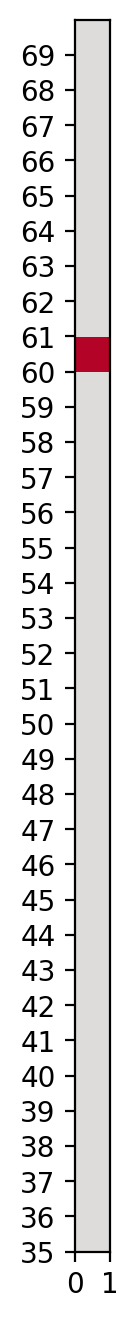

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(min(plot_size, len(info))):  # Iterate up to the length of info
    # Check if the 'atts' key exists before accessing it
    if "atts" in info[j]:
        atts = info[j]["atts"].max(axis=0)
        att_matrix[: (j + 1), j] = atts
    else:
        # Handle the case where 'atts' is missing
        # You can either skip this iteration or assign a default value to atts
        print(f"Warning: 'atts' key not found in info[{j}]. Skipping this iteration.")
        continue  # Skip to the next iteration

    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

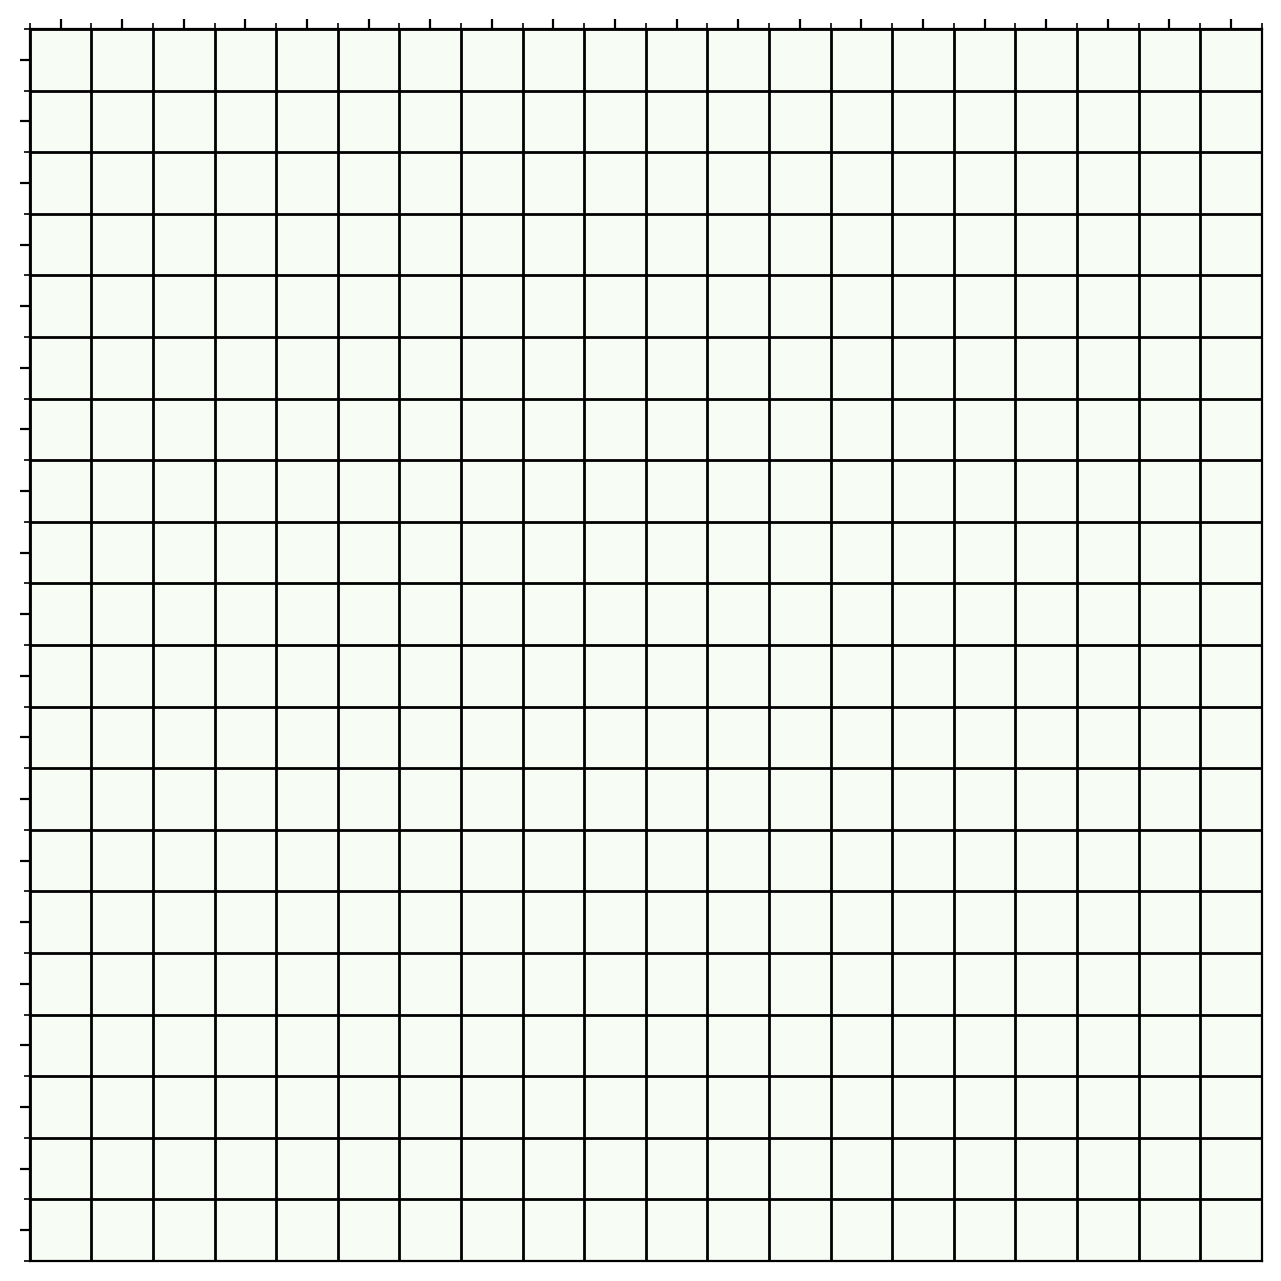

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()